In [1]:
import os
import sys
import time
import torch
import random
import scipy.io
import numpy as np
from pyDOE import lhs
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from collections import OrderedDict

mpl.rcParams.update(mpl.rcParamsDefault)
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.max_open_warning'] = 4

## Global functions

In [2]:
if torch.cuda.is_available():
    """ Cuda support """
    print('cuda available')
    device = torch.device('cuda')
else:
    print('cuda not avail')
    device = torch.device('cpu')

def seed_torch(seed):
    """ Seed initialization """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_torch(2341)
torch.cuda.empty_cache()

def tonp(tensor):
    """ Torch to Numpy """
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    elif isinstance(tensor, np.ndarray):
        return tensor
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

def grad(u, x):
    """ Get grad """
    gradient = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return gradient

cuda available


## Initializations

In [3]:
# File initializations
file_path = './'
file_name = 'losses.txt'

# Exact solution boundaries
data = scipy.io.loadmat(file_path + 'AC.mat')
Exact = data['uu']
Exact0 = np.real(Exact)
t0 = data['tt'].flatten()[:,None]
x0 = data['x'].flatten()[:,None]
lbc = torch.tensor([x0.min(), t0.min()]).to(torch.float32).to(device)
ubc = torch.tensor([x0.max(), t0.max()]).to(torch.float32).to(device)

## DNN

In [4]:
class DNN(torch.nn.Module):
    """ DNN Class """
    
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        # Layers
        layer_list = list()
        for i in range(self.depth - 1):
            w_layer = torch.nn.Linear(layers[i], layers[i+1], bias=True)
            torch.nn.init.xavier_normal_(w_layer.weight)
            layer_list.append(('layer_%d' % i, w_layer))
            layer_list.append(('activation_%d' % i, self.activation()))

        w_layer = torch.nn.Linear(layers[-2], layers[-1], bias=True)
        torch.nn.init.xavier_normal_(w_layer.weight)
        layer_list.append(('layer_%d' % (self.depth - 1), w_layer))
        layerDict = OrderedDict(layer_list)
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

## PINN

In [5]:
class PhysicsInformedNN():
    """ PINN Class """
    
    def __init__(self, X_u, u, X_r, X_rt, lb, ub, dimx, dimt, savept=None):
        
        # Initialization
        self.rba = 1  # RBA weights
        self.sa = 0   # SA weights
        self.neum = 0 # Neumann bc
        self.iter = 0
        self.exec_time = 0
        self.print_step = 100
        self.savept = savept
        self.dimx, self.dimt = dimx, dimt
        self.dimx_, self.dimt_ = 256*2, 201  # solution dim
        self.first_opt = 30000
        self.it = []; self.l2 = []; self.ll = []
        self.loss, self.losses = None, []

        # Intermediate results
        self.Exact = Exact0
        X, T = np.meshgrid(x0, t0)
        X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        self.xx = torch.tensor(X_star[:, 0:1]).float().to(device)
        self.tt = torch.tensor(X_star[:, 1:2]).float().to(device)
        
        # Data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_r = torch.tensor(X_r[:, 0:1], requires_grad=True).float().to(device)
        self.t_r = torch.tensor(X_r[:, 1:2], requires_grad=True).float().to(device)
        self.x_rt = torch.tensor(X_rt[:, 0:1], requires_grad=True).float().to(device)
        self.t_rt = torch.tensor(X_rt[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.ub = self.u[self.dimx:]
        self.u = self.u[:self.dimx]
        self.N_r = tonp(self.x_r).size
        self.N_u = tonp(self.u).size
        self.dnn = DNN(layers).to(device)
        
        # RBA initialization
        if self.rba == 1:
            self.rsum = 0
            self.eta = 0.001
            self.gamma = 0.999
            
        # SA weights initialization
        if self.sa == 1:
            self.lamr = torch.rand(self.N_r, 1, requires_grad=True).float().to(device)*1
            self.lamu = torch.rand(self.N_u, 1, requires_grad=True).float().to(device)*100
            self.lamr = torch.nn.Parameter(self.lamr)
            self.lamu = torch.nn.Parameter(self.lamu)
            # Optimizer2 (SA weights)
            self.optimizer2 = torch.optim.Adam([self.lamr] + [self.lamu], lr=0.005, maximize=True)
            
        # Optimizer (1st ord)
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=1e-3, betas=(0.9, 0.999))
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9, verbose=True)
        self.step_size = 5000

    def net_u(self, x, t):
        """ Get the velocities """
        
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_r(self, x, t):
        """ Residual calculation """
        
        u = self.net_u(x, t)
        u_t = grad(u, t)
        u_x = grad(u, x)
        u_xx = grad(u_x, x)
        f = u_t - 0.0001*u_xx + 5.0*u*u*u - 5.0*u
        return f, u_x

    def loss_func(self):
        """ Loss function """
        
        self.optimizer.zero_grad()
        if self.sa == 1:
            self.optimizer2.zero_grad()

        # Predictions
        self.u_pred = self.net_u(self.x_u, self.t_u)
        self.r_pred, u_x_pred = self.net_r(self.x_r, self.t_r)
        self.r_pred2, u_x_pred = self.net_r(self.x_u, self.t_u)

        if self.rba == True:
            r_norm = self.eta*torch.abs(self.r_pred)/torch.max(torch.abs(self.r_pred))
            self.rsum = (self.rsum*self.gamma + r_norm).detach()
            loss_r = torch.mean((self.rsum*self.r_pred)**2)
            loss_u = torch.mean(((self.u_pred[:self.dimx] - self.u)) ** 2)
            
        elif self.sa == True:
            loss_r = torch.mean((self.lamr*self.r_pred)**2)
            loss_u = torch.mean((self.lamu*(self.u_pred[:self.dimx] - self.u)) ** 2)

        else:
            loss_r = torch.mean(self.r_pred**2)
            loss_u = torch.mean(((self.u_pred[:self.dimx] - self.u)) ** 2)
        
        # Neumann bc
        if self.neum == 1:
            loss_ub = torch.mean((self.u_pred[self.dimx:self.dimx+self.dimt] - self.u_pred[-self.dimt:]) ** 2) + \
                      torch.mean((ub_x_pred[:self.dimt] - ub_x_pred[self.dimt:]) ** 2)
        else:
            loss_ub = 0

        # Loss calculation
        self.loss = loss_r + loss_u + loss_ub
        self.loss.backward()
        self.iter += 1

        if self.iter % self.print_step == 0:
            
            # Test prediction
            r_predt, u_x_predt = self.net_r(self.x_rt, self.t_rt)
            loss_test = torch.mean(r_predt ** 2)
            
            with torch.no_grad():
                # Grid prediction (for relative L2)
                res = self.net_u(self.xx, self.tt)
                sol = tonp(res)
                sol = np.reshape(sol, (self.dimt_, self.dimx_)).T

                # L2 calculation
                l2_rel = np.linalg.norm(self.Exact.flatten() - sol.flatten(), 2) / np.linalg.norm(self.Exact.flatten(), 2)
                l_inf = np.linalg.norm(self.Exact.flatten() - sol.flatten(), 2) / np.linalg.norm(self.Exact.flatten(), 2)
                print('Iter %d, Loss: %.3e, Test loss: %.3e, Rel_L2: %.3e, L_inf: %.3e, t/iter: %.1e' % 
                     (self.iter, self.loss.item(), loss_test.item(), l2_rel, l_inf, self.exec_time))
                print()
                
                self.it.append(self.iter)
                self.l2.append(l2_rel)
                self.ll.append(tonp(loss_test))

        # Optimizer step
        self.optimizer.step()
        self.losses.append(self.loss.item())
        if self.sa == True:
            self.optimizer2.step()
                
    def train(self):
        """ Train model """
        
        self.dnn.train()
        for epoch in range(self.first_opt):
            start_time = time.time()
            self.loss_func()
            end_time = time.time()
            self.exec_time = end_time - start_time
            if (epoch+1) % self.step_size == 0:
                self.scheduler.step()

        # Write data
        a = np.array(self.it)
        b = np.array(self.l2)
        c = np.array(self.ll)
        # Stack them into a 2D array.
        d = np.column_stack((a, b, c))
        file = open(file_path + file_name, "w+")
        file.close()
        file = open(file_path + file_name, "w+")
        file.close()
        # Write to a txt file
        np.savetxt('losses.txt', d, fmt='%.10f %.10f %.10f')

        if self.savept != None:
            torch.save(self.dnn.state_dict(), str(self.savept)+".pt")
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1]).float().to(device)
        t = torch.tensor(X[:, 1:2]).float().to(device)
        self.dnn.eval()
        u = self.net_u(x, t)
        u = tonp(u)
        return u

## Data generation

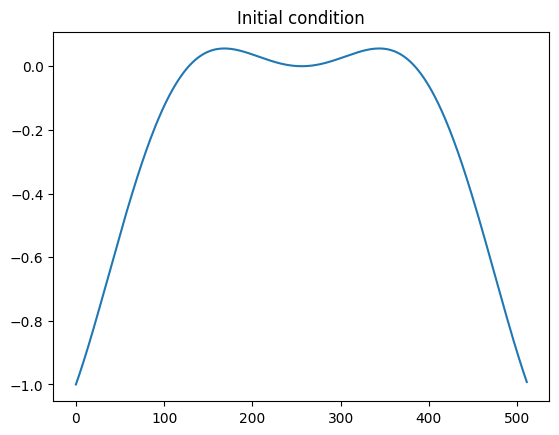

X_r shape: (25600, 2)
X_rt shape: (25600, 2)
X_u shape: (712, 2)
u shape: (712, 1)


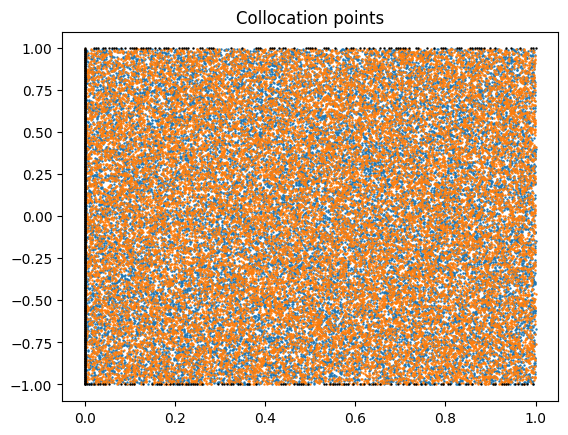

In [6]:
# Collocation points
dimx = 256*2
dimt = 201
N_u = 100
N_r = 25600
hidden = 128
layers = [2] + [hidden]*6 + [1]

# Definition
Exact = Exact0.T
tm = np.linspace(t0.min(), t0.max(), dimt)[:, None]
xm = np.linspace(x0.min(), x0.max(), dimx)[:, None]
X, T = np.meshgrid(xm, tm)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

plt.figure(1)
plt.title('Initial condition')
plt.plot(np.arange(uu1.shape[0]), uu1)
plt.show()

# Top/bot boundaries
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu2 = Exact[:,0:1]
uu3 = Exact[:,-1:]

# Random choice
idx = np.random.choice(dimt, N_u, replace=False)
idx2 = np.random.choice(dimt, N_u, replace=False)
u_train = np.vstack([uu1, uu2[idx, :], uu3[idx2, :]])
X_u_train = np.vstack([xx1, xx2[idx, :], xx3[idx2, :]])

# Collocation points
X_r_train = lb + (ub-lb)*lhs(2, N_r)
X_r_test = lb + (ub-lb)*lhs(2, N_r)

print('X_r shape:', X_r_train.shape)
print('X_rt shape:', X_r_test.shape)
print('X_u shape:', X_u_train.shape)
print('u shape:', u_train.shape)
            
plt.figure(2)
plt.title('Collocation points')
plt.scatter(X_r_train[:, 1], X_r_train[:, 0], s=0.5)
plt.scatter(X_r_test[:, 1], X_r_test[:, 0], s=0.5)
plt.scatter(X_u_train[:, 1], X_u_train[:, 0], s=0.5, c='k')
plt.show()

In [7]:
model = PhysicsInformedNN(X_u_train, u_train, X_r_train, X_r_test, lb, ub, dimx, dimt=N_u, savept='weights')

Adjusting learning rate of group 0 to 1.0000e-03.


## Training

In [8]:
%%time
model.train()

Iter 100, Loss: 1.774e-02, Test loss: 1.190e+00, Rel_L2: 7.557e-01, L_inf: 7.557e-01, t/iter: 1.7e-02

Iter 200, Loss: 1.181e-02, Test loss: 6.270e-01, Rel_L2: 7.656e-01, L_inf: 7.656e-01, t/iter: 1.7e-02

Iter 300, Loss: 1.589e-03, Test loss: 1.026e-01, Rel_L2: 7.359e-01, L_inf: 7.359e-01, t/iter: 1.7e-02

Iter 400, Loss: 1.123e-03, Test loss: 4.808e-02, Rel_L2: 7.738e-01, L_inf: 7.738e-01, t/iter: 1.7e-02

Iter 500, Loss: 7.455e-04, Test loss: 2.068e-02, Rel_L2: 8.154e-01, L_inf: 8.154e-01, t/iter: 1.7e-02

Iter 600, Loss: 5.681e-04, Test loss: 1.149e-02, Rel_L2: 8.293e-01, L_inf: 8.293e-01, t/iter: 1.7e-02

Iter 700, Loss: 6.341e-04, Test loss: 9.527e-03, Rel_L2: 8.171e-01, L_inf: 8.171e-01, t/iter: 1.7e-02

Iter 800, Loss: 7.115e-04, Test loss: 7.097e-03, Rel_L2: 8.061e-01, L_inf: 8.061e-01, t/iter: 1.7e-02

Iter 900, Loss: 2.094e-01, Test loss: 9.101e-01, Rel_L2: 9.960e-01, L_inf: 9.960e-01, t/iter: 1.7e-02

Iter 1000, Loss: 9.831e-04, Test loss: 5.530e-03, Rel_L2: 7.650e-01, L_in

L2: 0.025224140844888943


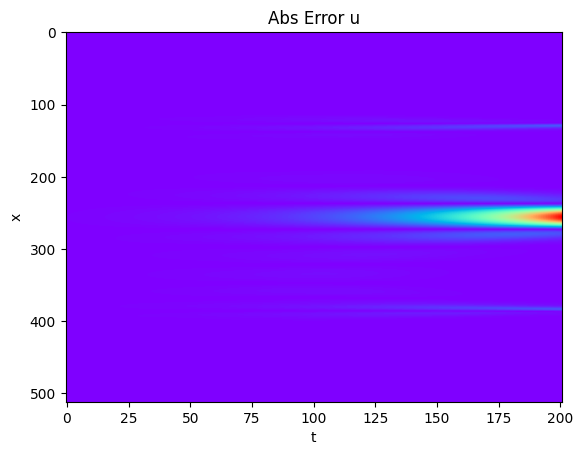

In [9]:
# Prediction
Exact = Exact0
X, T = np.meshgrid(x0, t0)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred = model.predict(X_star)
U_pred = np.reshape(u_pred, (Exact.shape[1], Exact.shape[0])).T
l2_rel = np.linalg.norm(Exact.flatten() - U_pred.flatten()) / np.linalg.norm(Exact.flatten(), 2)
print('L2:', l2_rel)

plt.figure(1)
plt.title('Abs Error u')
plt.xlabel('t')
plt.ylabel('x') 
plt.imshow(np.abs(Exact-U_pred), aspect='auto', cmap='rainbow')
plt.show()